## Cost Analysis of Eggs
Dates are from January 1st 2019 to December 31st 2024. Based on grade A Large eggs, both conventionally and organically produced and sold in the United States. The data source is https://marsapi.ams.usda.gov/. 

In [1]:
import os
import csv
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
# Load the csv file
csv_path = Path("Resources/5_year_eggs.csv")
csv_path_2 = Path("Resources/USDA_Eggs_5_Years.csv")

In [3]:
# Read in CSV file and create a DataFrame
usda_5y = pd.read_csv("Resources/USDA_Eggs_5_Years.csv")

# Remove columns
usda_5y.drop(['office_name', 'office_code', 'office_city', 'office_state', 'published_date', 'commodity', 'slug_id', 'slug_name',
                'report_title', 'final_ind', 'report_date', 'community', 'condition', 'price_unit', 'price_min', 'price_max'], axis=1, inplace=True)
# Filter for shell egg and package size 12
filtered_usda = usda_5y.loc[(usda_5y["section"] == "Shell Egg")]
filtered_usda

# Find the weighted data_frame for true average
weighted_usda = filtered_usda[["report_begin_date", "report_end_date", "region", "section", "type", "quality_grade", "package_size", "environment", "price_avg", "store_count"]]
weighted_usda["weighted"] = weighted_usda["price_avg"] * weighted_usda["store_count"] 
weighted_usda["weighted"]= weighted_usda["weighted"] / weighted_usda["store_count"].sum()

weighted_usda.head()

,report_begin_date,report_end_date,region,section,type,quality_grade,package_size,environment,price_avg,store_count,weighted
0,1/5/2019,1/11/2019,National,Shell Egg,WHITE LARGE,AA,NaN,Conventional,1.26,140.0,0.000038
1,1/5/2019,1/11/2019,National,Shell Egg,WHITE LARGE,AA,NaN,Conventional,2.24,188.0,0.000092
2,1/5/2019,1/11/2019,National,Shell Egg,WHITE EXTRA LARGE,A,NaN,Conventional,2.00,288.0,0.000126
3,1/5/2019,1/11/2019,National,Shell Egg,WHITE LARGE,A,NaN,Conventional,1.11,1404.0,0.000340
4,1/5/2019,1/11/2019,National,Shell Egg,WHITE LARGE,A,NaN,Conventional,2.61,231.0,0.000131


In [4]:
# Convert column report_end_date to datetime and extract the month and year
weighted_usda["report_end_date"] = pd.to_datetime(weighted_usda["report_end_date"], format="%m/%d/%Y")
weighted_usda["month"] = weighted_usda["report_end_date"].dt.month
weighted_usda["year"] = weighted_usda["report_end_date"].dt.year
weighted_usda.head()

,report_begin_date,report_end_date,region,section,type,quality_grade,package_size,environment,price_avg,store_count,weighted,month,year
0,1/5/2019,2019-01-11,National,Shell Egg,WHITE LARGE,AA,NaN,Conventional,1.26,140.0,0.000038,1,2019
1,1/5/2019,2019-01-11,National,Shell Egg,WHITE LARGE,AA,NaN,Conventional,2.24,188.0,0.000092,1,2019
2,1/5/2019,2019-01-11,National,Shell Egg,WHITE EXTRA LARGE,A,NaN,Conventional,2.00,288.0,0.000126,1,2019
3,1/5/2019,2019-01-11,National,Shell Egg,WHITE LARGE,A,NaN,Conventional,1.11,1404.0,0.000340,1,2019
4,1/5/2019,2019-01-11,National,Shell Egg,WHITE LARGE,A,NaN,Conventional,2.61,231.0,0.000131,1,2019


In [5]:
# start the weighted average calculation by multipling the avg and store count
group_year_month = weighted_usda[["price_avg", "store_count", "weighted", "month", "year"]]
group_year_month["weighted_yearly"] = weighted_usda["price_avg"] * weighted_usda["store_count"]
group_year_month.head()

/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_22975/1053679360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group_year_month["weighted_yearly"] = weighted_usda["price_avg"] * weighted_usda["store_count"]


,price_avg,store_count,weighted,month,year,weighted_yearly
0,1.26,140.0,0.000038,1,2019,176.40
1,2.24,188.0,0.000092,1,2019,421.12
2,2.00,288.0,0.000126,1,2019,576.00
3,1.11,1404.0,0.000340,1,2019,1558.44
4,2.61,231.0,0.000131,1,2019,602.91


In [6]:
# iterate over the rows and calculate the weighted average, group by month and year
weighted_year_month = group_year_month.groupby(["year", "month"]).apply(lambda x: x["weighted_yearly"].sum() / x["store_count"].sum()).reset_index()
# assign column names
weighted_year_month.columns = ["year", "month", "weighted_monthly"]
weighted_year_month.head()

/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_22975/2934143590.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  weighted_year_month = group_year_month.groupby(["year", "month"]).apply(lambda x: x["weighted_yearly"].sum() / x["store_count"].sum()).reset_index()


,year,month,weighted_monthly
0,2019,1,2.313460
1,2019,2,2.571012
2,2019,3,2.552674
3,2019,4,2.397530
4,2019,5,2.133107


In [7]:
# create a new dataframe that combines the weighted average and the store count grouped by year and month
store_count_summary = group_year_month.groupby(['year', 'month'])['store_count'].sum().reset_index()
store_count_summary.head()

,year,month,store_count
0,2019,1,56613.0
1,2019,2,67505.0
2,2019,3,92030.0
3,2019,4,92143.0
4,2019,5,105960.0


In [8]:
year_month_summary = pd.merge(weighted_year_month, store_count_summary, on=["year", "month"], how="inner")
year_month_summary["Year and Month"] = pd.to_datetime(year_month_summary["month"].astype(str) + '-' + year_month_summary["year"].astype(str), dayfirst=True)
year_month_summary.set_index("Year and Month", inplace=True)
year_month_summary

/var/folders/r8/0727psjx7xxc677bb6k0w6wh0000gp/T/ipykernel_22975/3390167591.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  year_month_summary["Year and Month"] = pd.to_datetime(year_month_summary["month"].astype(str) + '-' + year_month_summary["year"].astype(str), dayfirst=True)


,year,month,weighted_monthly,store_count
Year and Month,,,,
2019-01-01,2019,1,2.313460,56613.0
2019-02-01,2019,2,2.571012,67505.0
2019-03-01,2019,3,2.552674,92030.0
2019-04-01,2019,4,2.397530,92143.0
2019-05-01,2019,5,2.133107,105960.0
...,...,...,...,...
2024-08-01,2024,8,2.898926,39948.0
2024-09-01,2024,9,4.511288,36942.0
2024-10-01,2024,10,5.251904,38554.0


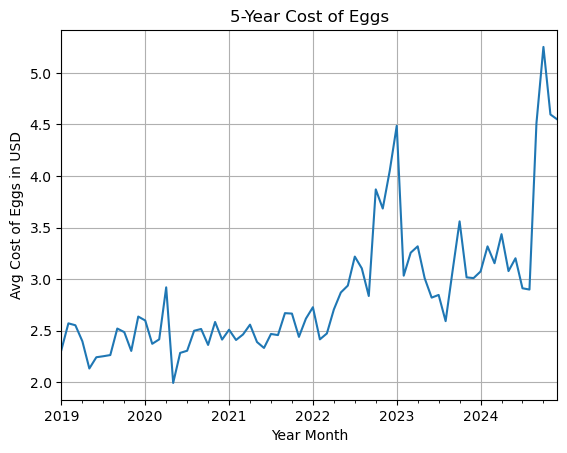

In [9]:
# Create a line graph of the change in cost in eggs over 5 years. 
year_month_summary.plot(kind="line", y="weighted_monthly", legend=False)
plt.xlabel("Year Month")
plt.ylabel("Avg Cost of Eggs in USD")
plt.title("5-Year Cost of Eggs")
plt.grid(True)
plt.show()

In [24]:
# Calculate the mean per year. Perform a weighted avg calculation grouped by year
mean = group_year_month.groupby(["year"]).apply(lambda x: x["weighted_yearly"].sum() / x["store_count"].sum(),
                                                                  include_groups=False)
mean.columns = ["year", "weighted avg per year"]
mean

year
2019    2.378807
2020    2.436470
2021    2.503465
2022    2.775660
2023    3.024127
2024    3.637499
dtype: float64

In [23]:
# Calculate the median per year. 
median = group_year_month.groupby("year")["price_avg"].median()
median.columns = ["median"]
median

year
2019    2.29
2020    2.33
2021    2.42
2022    2.76
2023    3.00
2024    3.67
Name: price_avg, dtype: float64

In [22]:
# Calculate the variance in the price average per year
var = group_year_month.groupby("year")["price_avg"].var()
var.columns = ["variance"]
var

year
2019    1.191303
2020    1.117709
2021    0.987271
2022    1.165135
2023    1.853367
2024    3.355468
Name: price_avg, dtype: float64

In [21]:
# Calculate the standard deviation of the price average
std_dev = group_year_month.groupby("year")["price_avg"].std()
std_dev.columns = ["Standard Deviation"]
std_dev

year
2019    1.091468
2020    1.057217
2021    0.993615
2022    1.079414
2023    1.361384
2024    1.831794
Name: price_avg, dtype: float64

In [20]:
# calculate the SEM for the dataset
sem = std_dev/np.sqrt(std_dev).count()
sem.columns = ["Standard Error of Mean"]
sem

year
2019    0.181911
2020    0.176203
2021    0.165602
2022    0.179902
2023    0.226897
2024    0.305299
Name: price_avg, dtype: float64

In [27]:
# Create a summary table
yearly_summary = ({"Mean": mean,
                   "Median": median,
                  "Variance": var,
                  "Standard Deviation": std_dev,
                  "Standard Error of Mean": sem})
yearly_summary_df = pd.DataFrame(yearly_summary)
yearly_summary_df

,Mean,Median,Variance,Standard Deviation,Standard Error of Mean
year,,,,,
2019,2.378807,2.29,1.191303,1.091468,0.181911
2020,2.436470,2.33,1.117709,1.057217,0.176203
2021,2.503465,2.42,0.987271,0.993615,0.165602
2022,2.775660,2.76,1.165135,1.079414,0.179902
2023,3.024127,3.00,1.853367,1.361384,0.226897
2024,3.637499,3.67,3.355468,1.831794,0.305299


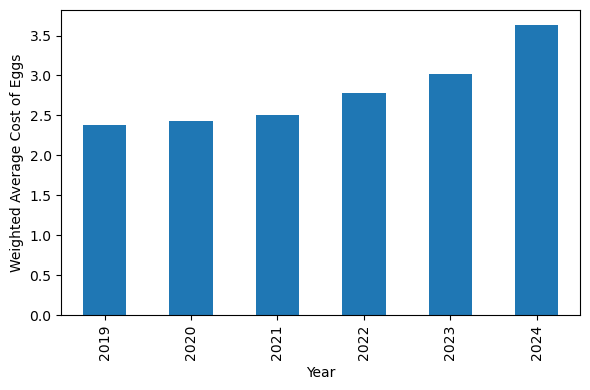

In [36]:

yearly_summary_compare = mean.plot(kind="bar", figsize=(6,4))
yearly_summary_compare.set_xlabel("Year")
yearly_summary_compare.set_ylabel("Weighted Average Cost of Eggs")

plt.tight_layout()
plt.show()

## Bureau of Labor Statistics Consumer Price Index information

In [28]:
# Create a dataframe from the Bureau of Labor Statistics CPI (csv_path 5_year_eggs.csv)
eggs_df = pd.read_csv(csv_path, low_memory=False)
eggs_df

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,2019,1.554,1.557,1.544,1.463,1.362,1.203,1.243,1.219,1.383,1.282,1.405,1.535
1,2020,1.461,1.449,1.525,2.019,1.640,1.554,1.401,1.328,1.353,1.408,1.450,1.481
2,2021,1.466,1.597,1.625,1.620,1.625,1.642,1.642,1.709,1.835,1.821,1.718,1.788
3,2022,1.929,2.005,2.046,2.520,2.863,2.707,2.936,3.116,2.902,3.419,3.589,4.250
4,2023,4.823,4.211,3.446,3.270,2.666,2.219,2.094,2.043,2.065,2.072,2.138,2.507
5,2024,2.522,2.996,2.992,2.864,2.699,2.715,3.080,3.204,3.821,3.370,3.649,4.146


In [29]:
# Use the Melt function to change the format from wide to long
eggs_monthly = pd.melt(eggs_df, id_vars=["Year"], var_name="Month", value_name="Avg Cost of Eggs")
eggs_monthly.head()

,Year,Month,Avg Cost of Eggs
0,2019,Jan,1.554
1,2020,Jan,1.461
2,2021,Jan,1.466
3,2022,Jan,1.929
4,2023,Jan,4.823


In [30]:
# Combine year and month into 1 field 
eggs_monthly["Year Month"] = pd.to_datetime(eggs_monthly["Year"].astype(str) + '-' + eggs_monthly["Month"], format="%Y-%b")
eggs_monthly = eggs_monthly[["Year Month", "Avg Cost of Eggs"]]
eggs_monthly["Avg Cost of Eggs"] = eggs_monthly["Avg Cost of Eggs"].round(2)
eggs_monthly = eggs_monthly.set_index("Year Month").sort_index(ascending=True)
eggs_monthly.head()

,Avg Cost of Eggs
Year Month,
2019-01-01,1.55
2019-02-01,1.56
2019-03-01,1.54
2019-04-01,1.46
2019-05-01,1.36


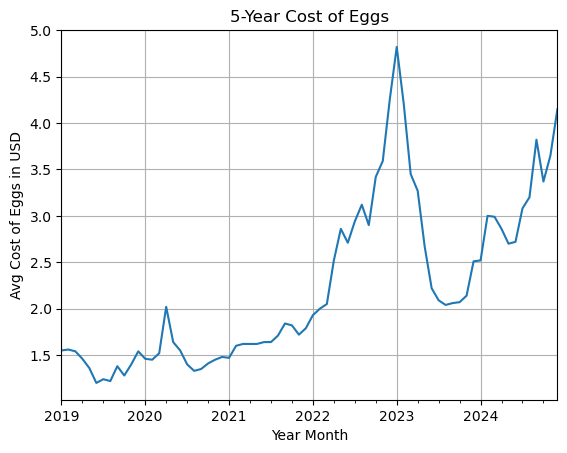

In [31]:
# Create a line graph of the change in cost in eggs over 5 years. 
eggs_monthly.plot(kind="line", y="Avg Cost of Eggs", legend=False)
plt.xlabel("Year Month")
plt.ylabel("Avg Cost of Eggs in USD")
plt.title("5-Year Cost of Eggs")
plt.grid(True)
plt.show()